In [1]:
import pandas as pd
import numpy as np
import amro
import seaborn as sns
import matplotlib_inline.backend_inline
from IPython.core.display import HTML

# Context for figures in jupyter notebook
sns.set(rc={"figure.dpi":200, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# My obsessive brain needs centered figures:
# https://stackoverflow.com/a/66493988
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Data
The contact matrix we are using is the same as in Tal Robin's paper:
https://doi.org/10.1371/journal.pone.0290821 its divided into two files: **wards** and **patients**


### Wards
The wards dataset contains information on each of the hospital's wards. The following are the variables in the dataset:
* Day refers to the moment in time (day). These data span 1399 consecutive days (02/01/2009 to 11/30/2012) with the first day marking day 0. 
* Ward refers to the ward the individual was in. Individuals in the same ward are assumed to have higher levels of contamination. 
* Count refers to the number of individuals per day in each of the ward. Individuals that spent the day in more than one ward are counted as percentages. For example, an individual that spent their day in three wards counts as 0.33 for each of the wards they were in. 

In [2]:
total_patients_per_ward = pd.read_csv("../data/wards_py.csv")
total_patients_per_ward.head()

,day,ward,count
0,0,1,3.0
1,0,2,8.0
2,0,3,23.0
3,0,4,16.0
4,0,5,3.0


### Patients
The patients dataset contains information on each of the patients with anonnymized MRNs. The following are the variables in the dataset:
* `day` refers to the moment in time (day). These data span 1399 consecutive days (02/01/2009 to 11/30/2012) with the first day marking day 0. 
* `ward` refers to the ward the individual was in. Individuals in the same ward are assumed to have higher levels of contamination. This ward corresponds to the one in the **wards** dataset. 
* `MRN` is an annonymized unique identifier of the patient. 
* `is_new` indicates whether the patient just came into the hospital (`is_new = 1`) or they were hospitalized the day before (`is_new = 0`). This indicator helps the contamination variable. 
* `weight` is the weight of the individual for each ward. It is calculated as: `1/(number of wards mrn was in day d)`
* `next_day` refers to the row number in which that individual appears again in the dataset in `dat + 1` (this is for speed purposes of the algorithm). Negative values imply that the individual never came back to the hospital. 

In [3]:
ward_matrix = pd.read_csv("../data/patients_py.csv")
ward_matrix.head()

,day,ward,MRN,is_new,weight,next_day
0,0,1,1,1,1.0,1510
1,0,1,2,1,1.0,1511
2,0,1,3,1,1.0,1512
3,0,2,4,1,1.0,1513
4,0,2,5,1,1.0,1514


# Model

The model is programmed in the `amro` library. It uses `C++` functions to fastly compute in parallel realizations of the model with different parameters.  You can access the `help` for a description of all of the included functions:


In [4]:
help(amro)

Help on module amro:

NAME
    amro - Module implementing a stochastic model of antimicrobial resistant organisms in a healthcare facility.

FUNCTIONS
    progress_patients_1_timestep(...) method of builtins.PyCapsule instance
        progress_patients_1_timestep(ward_matrix: Numpy.ndarray[numpy.float64] = 1, total_patients_per_ward: Numpy.ndarray[numpy.float64] = 2, parameters: Numpy.ndarray[numpy.float64] = 3) -> Numpy.ndarray[numpy.float64]
        
        
        @title Progress patients across all wards
        
        @description Progresses all the patients across all wards one timestep. Consider
        a group of individuals in the same ward. Let `C_i(t)` denote whether individual `i` is colonized
        `C_i(t) = 1` or not colonized `C_i(t) = 0` at time `t`. The probability of an individual being colonized
        at time `t + 1` is given by:
        
                        (1 - alpha)*w_i + (1 - w_i)(beta / N)*sum(w_i * C_i) + gamma*h_i
        
        @param ward_matr

## Equations

In this section we discuss the model's equations. In particular we start with a simplified model that doesn't consider the possibility of importing cases and then we move to the model with importation. 

### Simplified model without importated cases
The model is defined for an individual $i$ with colonization status $C_{i,d} \in \{ 0, 1\}$ at day $d$. For an individual that was already in the hospital, the probability of an individual being colonized at day $d$ considering their colonization status at day $d-1$ is given by:
\begin{equation}
\begin{aligned}
    \mathbb{P}\big( C_{i,d} & = c_{i,d} | C_{i,d-1} = c_{i,d-1}\big) = \underbrace{(1 - \alpha) \cdot c_{i,d} \cdot c_{i,d-1} }_{T_{1 \to 1}} + \underbrace{\alpha  \cdot (1 - c_{i,d}) \cdot  c_{i,d-1} }_{T_{1 \to 0}} + \underbrace{\frac{\beta}{N_{w_i}^d} c_{i,d}(1 -  c_{i,d-1})  \cdot \sum\limits_{j\in w_i^{d}} c_{j,d-1}}_{T_{0 \to 1}} + \underbrace{(1 -  c_{i,d})(1 -  c_{i,d-1})  \cdot \bigg(1 - \frac{\beta}{N_{w_i}^d} \sum\limits_{j\in w_i^{d}} c_{j,d-1}\bigg)}_{T_{0 \to 0}}
\end{aligned}
\end{equation}
where $N_{w_i}^d$ and $c_{i,d} \in \left\{0,1\right\}$ are known constants, $\alpha, \beta$ represent the model's parameters. 

The variables represent the following:
* $c_{i,d}$ Colonized status of patient $i$ at day $d$ (either $0$ for not colonized or $1$ for colonized)
* $N_{w_i}^d$ Size (number of patients) of the ward where patient $i$ is hospitalized at day $d$. Sizes can be fractional: if a patient was in multiple wards in one day their contribution to each ward is proportional to the number of wards (say if a patient was in two wards they add $0.5$ to each). 
* $\alpha$ Decolonization probability. An colonized individual can become decolonized with probability $\alpha$. 
* $\beta$ Transmission rate of the colonization such that  $\beta/N_{w_i}^d$ is the probability of being colonized at day $d$. 

### Complete model with imported cases
The model with importation can be written as:
\begin{equation}
    \mathbb{P}\left( C_{i,d} = c_{i,d} | C_{i,d-1} = c_{i,d-1}\right) = ( T_{1\to 1} + T_{0\to 0} + T_{1 \to 0} + T_{0\to 1} ) (1 - h_{i,d}) + \big[ \gamma \cdot  c_{i,d} + (1 - \gamma) \cdot (1 - c_{i,d})\big] h_{i,d}
\end{equation}
where $h_{i,d}$ is a known constant with values in $\left\{0,1\right\}$ and $\gamma$ is a parameter. 

The variables represent the following:
* The value $h_{i,d} = 1$ represents that the patient has just arrived into the healthcare facility while $h_{i,d} = 0$ represents the patient having already been in the facility at day $d - 1$. 
* $\gamma$ represents the probability that a newly arrived patient is already colonized (was colonized outside the healthcare facility). 

## Running the algorithm
The algorithm works with numpy arrays so we need to convert everything to array.

In [5]:
#Convert the total patients
total_patients_per_ward = np.array(total_patients_per_ward)

#Get the initial patients to start the algorithm
initial_patients = ward_matrix[ward_matrix["day"] == 0].shape[0]

#Convert the rest of the patients
ward_matrix = np.array(ward_matrix)

Create a simulation with 100 parameters

In [6]:
#Set a seed for the numpy simulations
np.random.seed(47935)

#Assign a c++ seed
cpp_seed = np.random.randint(np.iinfo(np.int32).max)

#Create 100 simulations and run them in ~ 20 seconds
num_parameters = 100

#Initial colonized values represent the probability that each patient starts up colonized
colonized_day_0 = 0.2*np.ones(shape = (initial_patients, num_parameters))

#Create the parameter matrix
parameters = np.array([
                    np.random.uniform(0.1, 0.4, num_parameters), #Alpha
                    np.random.uniform(0.5, 1.0, num_parameters), #Beta
                    np.random.uniform(0.0, 1.0, num_parameters), #Beta, #Gamma
                    ]).transpose()

#Run 100 simulations with the same initial state just different parameters. 
simulations_100 = amro.simulate_discrete_model(colonized_day_0, ward_matrix, total_patients_per_ward, parameters, cpp_seed)

In [7]:
#Result is a matrix with as many rows as `ward_matrix` and each column is a simulation starting from column 6 and onwards
simulations_100[:10]

array([[ 0.,  1.,  1., ...,  1.,  1.,  0.],
       [ 0.,  1.,  2., ...,  1.,  1.,  1.],
       [ 0.,  1.,  3., ...,  1.,  1.,  0.],
       ...,
       [ 0.,  2.,  8., ...,  1.,  0.,  0.],
       [ 0.,  2.,  9., ...,  1.,  1.,  0.],
       [ 0.,  2., 10., ...,  1.,  1.,  0.]])

Text(0.5, 0, 'Day')

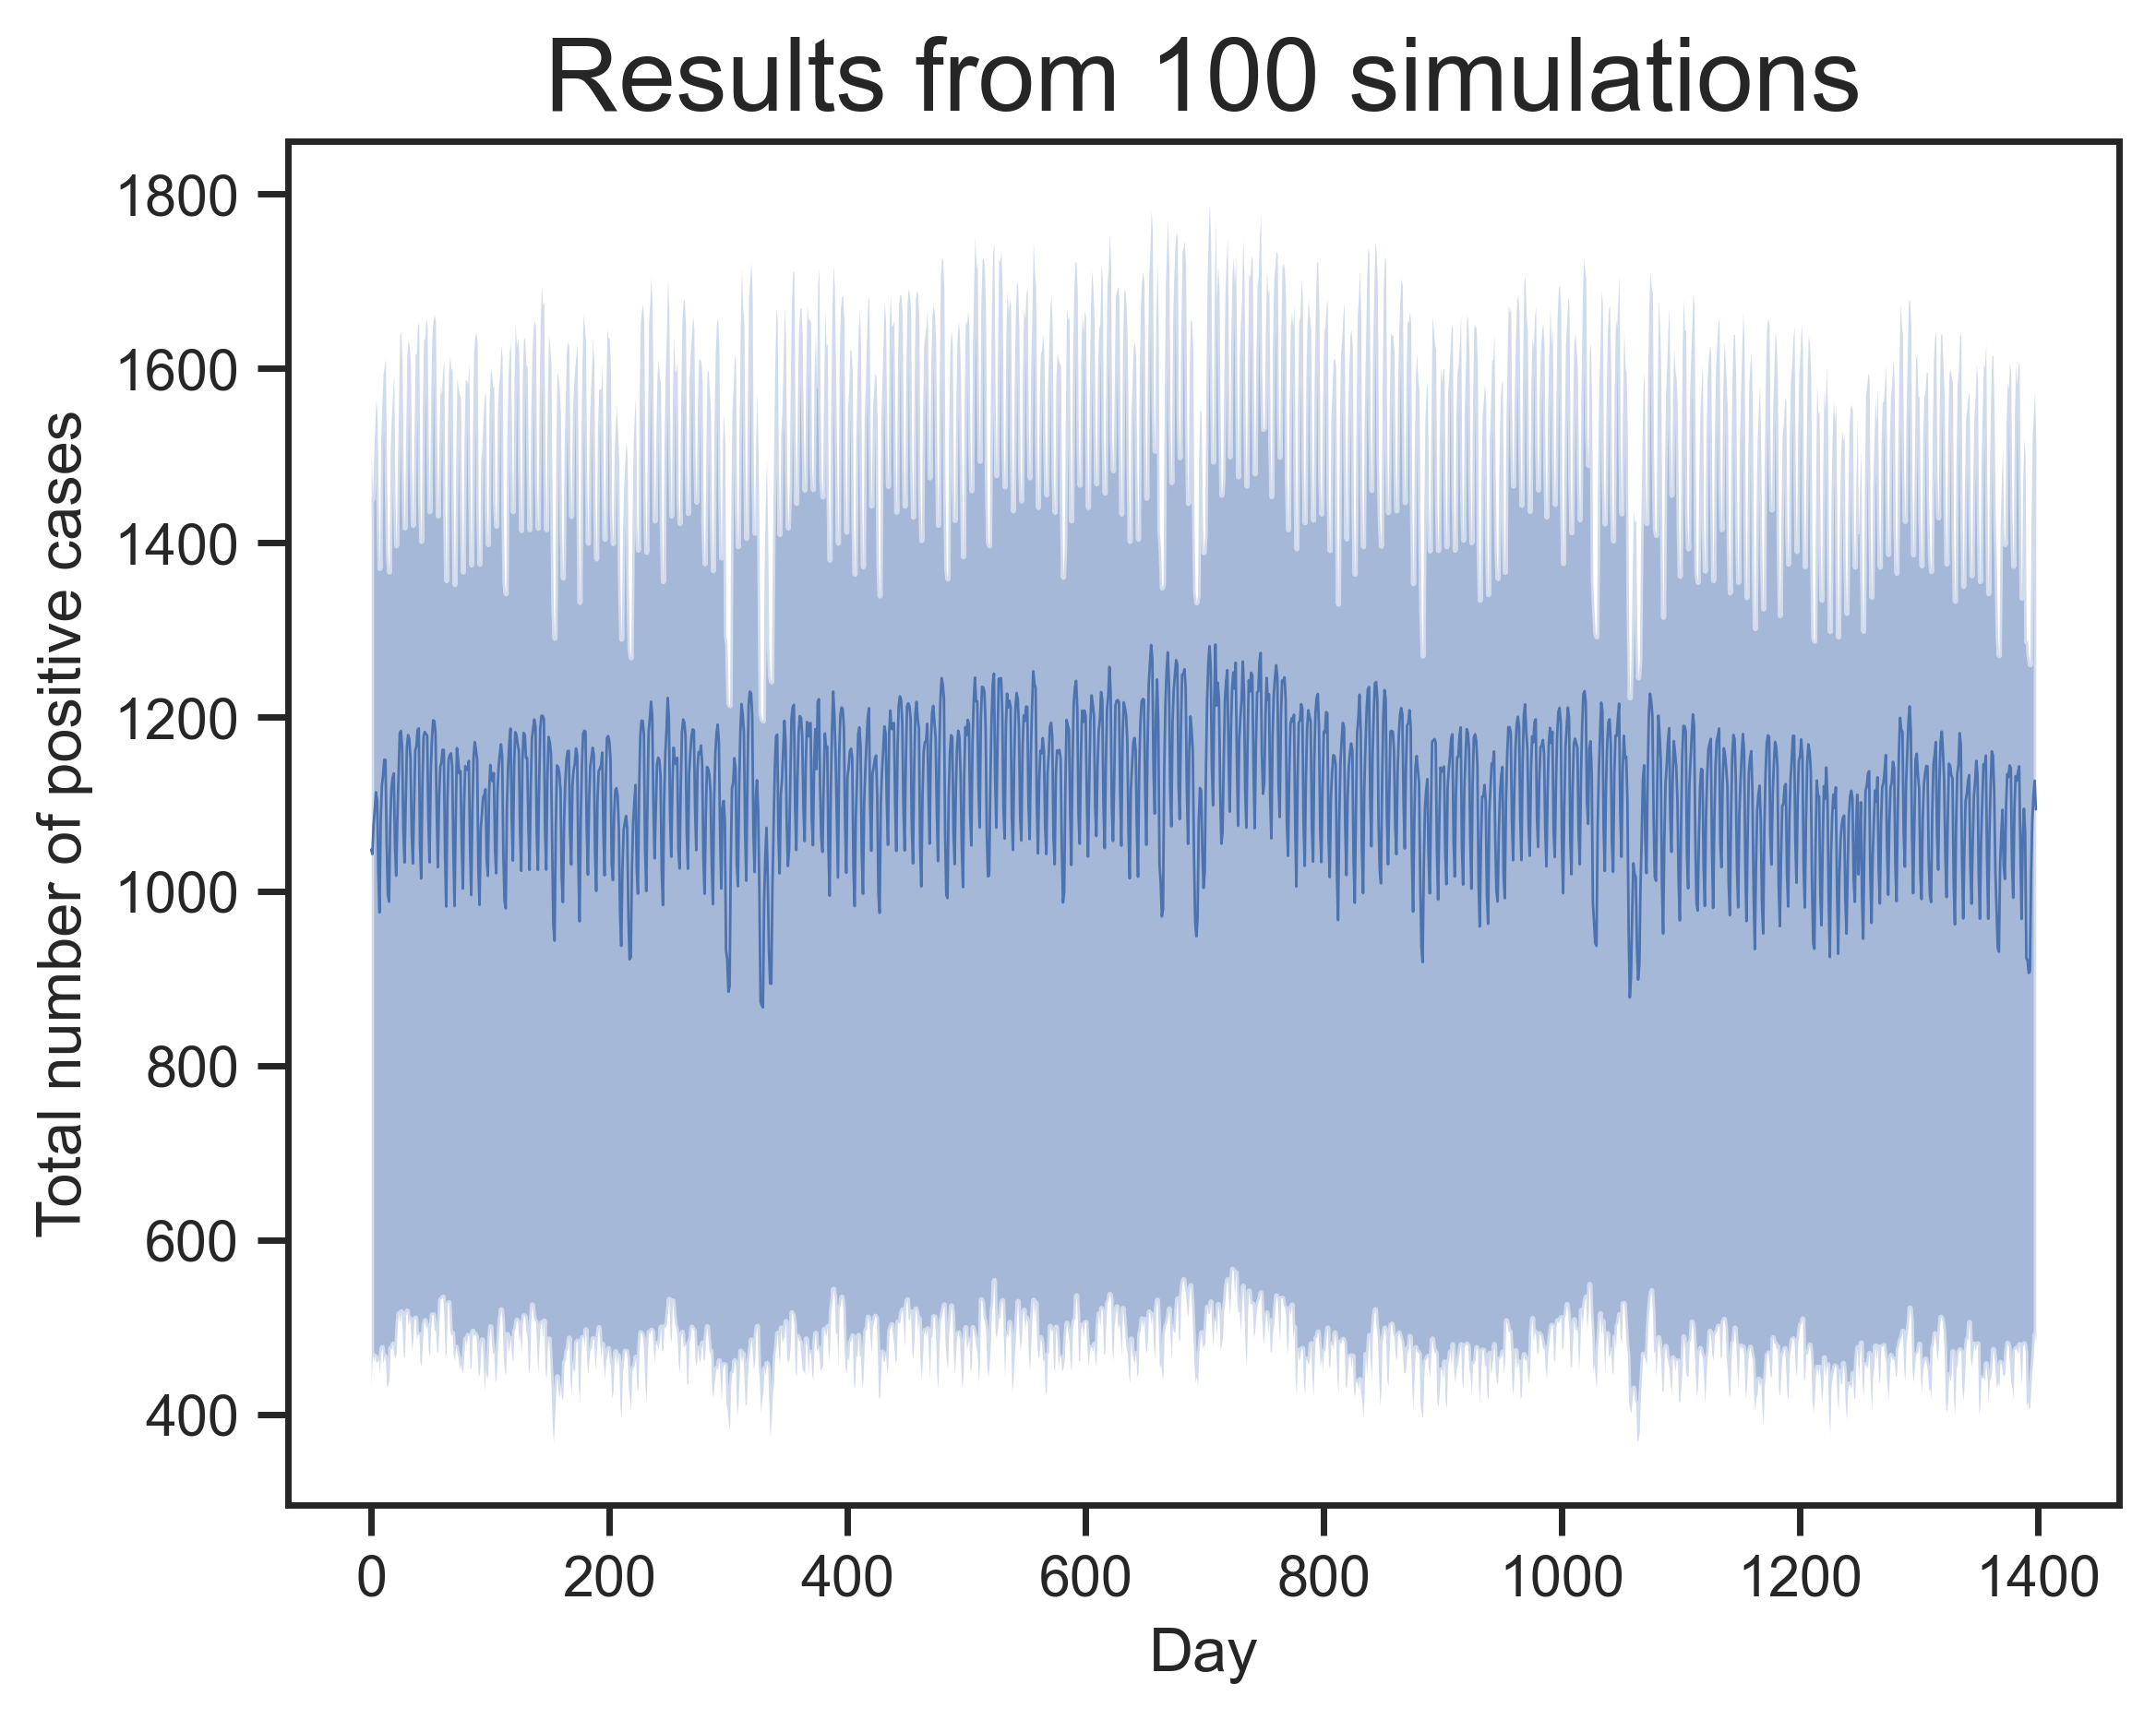

In [8]:
#We can aggregate the results with the `summary_of_total_positive` function and obtain quantiles
quantiles_total_pos = amro.summary_of_total_positive(simulations_100, quantiles=np.array([0.05, 0.95]))

#Plot
ax = sns.lineplot(x = quantiles_total_pos[:,0], y = quantiles_total_pos[:,1], linewidth = 0.5)
ax.fill_between(quantiles_total_pos[:,0], quantiles_total_pos[:,3], quantiles_total_pos[:,4], alpha=0.5)
ax.set_title('Results from 100 simulations', fontsize=20)
ax.set_ylabel('Total number of positive cases')
ax.set_xlabel('Day')